In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve

In [ ]:
df_customer_profile = pd.read_csv('/content/drive/MyDrive/Datasets/customer_profile_kmeans.csv', index_col=0) 
df_customer_profile.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346.0,326,2,0.00,low
12347.0,3,151,3598.21,high
12348.0,76,31,1797.24,low
12349.0,19,73,1757.55,medium
12350.0,311,17,334.40,low


In [ ]:
customer_profile = df_customer_profile.to_numpy()

In [ ]:
def plot_learning_curve(pipeline, X, y, scorer='accuracy', cv=5, train_sizes=np.linspace(.1, 1.0, 5), 
                        shuffle=False, random_state=None):

    train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, train_sizes=train_sizes, cv=cv,
                                                            scoring=scorer, n_jobs=-1, shuffle=shuffle,
                                                            random_state=random_state)

    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)
    mean_test_score = np.mean(test_scores, axis=1)
    std_test_score = np.std(test_scores, axis=1)

    plt.title(str(pipeline['estimator'].__class__.__name__) + ' learning curve')
    plt.xlabel('training set size')
    plt.ylabel('score')

    plt.plot(train_sizes, mean_train_score, label='train score', color='navy', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_train_score + std_train_score,
                     mean_train_score - std_train_score, color='navy', alpha=0.2)
    plt.plot(train_sizes, mean_test_score, label='cross-validation score', color='darkorange', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_test_score + std_test_score,
                     mean_test_score - std_test_score, color='darkorange', alpha=0.2)

    plt.legend(loc='lower right').get_frame().set_facecolor('white')

In [ ]:
def plot_validation_curve(pipeline, X, y, param_grid, param_name, scorer='accuracy', cv=5):
    
    param_range = param_grid[param_name]
    train_scores, test_scores = validation_curve(pipeline, X, y, param_name=param_name, param_range=param_range,
                                                 cv=cv, scoring=scorer, n_jobs=-1)

    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)
    mean_test_score = np.mean(test_scores, axis=1)
    std_test_score = np.std(test_scores, axis=1)

    plt.title(str(pipeline['estimator'].__class__.__name__) + ' validation curve')
    plt.xlabel(param_name)
    plt.ylabel('score')

    plt.plot(param_range, mean_train_score, label='training score', color='navy', marker='.', lw=2)
    plt.fill_between(param_range, mean_train_score - std_train_score,
                     mean_train_score + std_train_score, alpha=0.2, color='navy')
    plt.plot(param_range, mean_test_score, label='cross-validation score', color='darkorange', marker='.', lw=2)
    plt.fill_between(param_range, mean_test_score - std_test_score,
                     mean_test_score + std_test_score, alpha=0.2, color='darkorange')

    plt.legend(loc='lower right').get_frame().set_facecolor('white')

In [ ]:
def print_pretty_cv_results(grid):
    df = pd.DataFrame(grid.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')
    df['params'] = df['params'].apply(lambda param_dict: {k.replace('estimator__', ''): v for k, v in param_dict.items()})
    df.rename(columns={'mean_test_score': 'mean_val_score', 
                       'rank_test_score': 'rank_val_score'}, inplace=True)
    
    def highlight_equal(s, value, column):
        is_max = pd.Series(data=False, index=s.index)
        is_max[column] = s.loc[column] == value
        return ['background-color: lightyellow' if is_max.any() else '' for v in is_max]

    return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()

# Splitting train and test set

In [ ]:
X, y = customer_profile[:, :-1], customer_profile[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

# Support Vector Classifier

In [ ]:
from sklearn.svm import SVC

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', SVC())])

tuned_parameters = {'estimator__C': (1, 10, 100, 1000)}

svc_grid = GridSearchCV(pipeline,
                        param_grid=tuned_parameters,
                        scoring='accuracy',
                        cv=5,  # 5 fold cross validation
                        n_jobs=-1,  # use all processors
                        refit=True,  # refit the best model on the full development set
                        return_train_score=True,
                        verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
print_pretty_cv_results(svc_grid)

<ipython-input-7-4367a86138e8>:12: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()


params,mean_train_score,mean_val_score,rank_val_score
{'C': 1000},0.996274,0.990688,1
{'C': 100},0.993325,0.989135,2
{'C': 10},0.987271,0.986652,3
{'C': 1},0.967634,0.965233,4


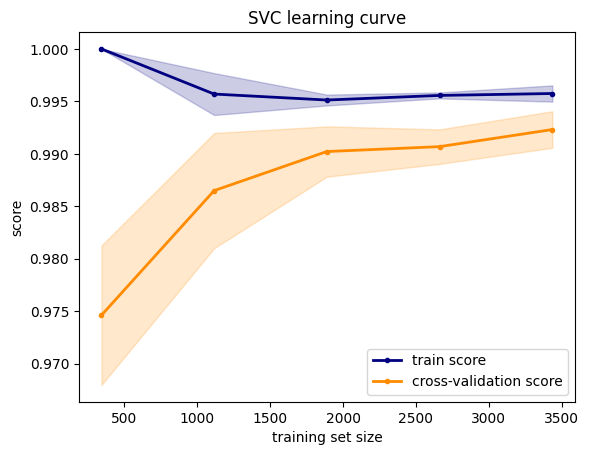

In [ ]:
plot_learning_curve(svc_grid.best_estimator_, X, y)


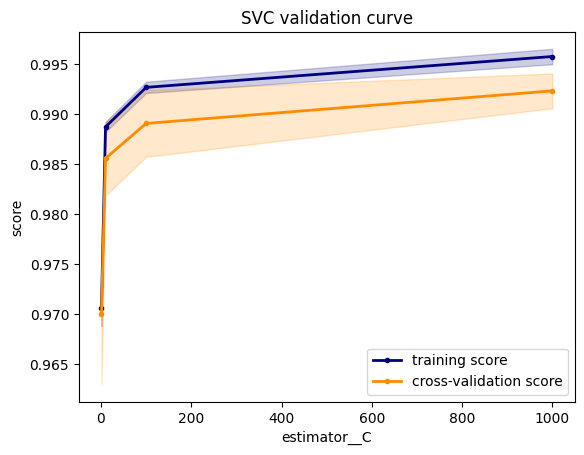

In [ ]:
plot_validation_curve(svc_grid.best_estimator_, X, y, param_grid=tuned_parameters, param_name='estimator__C')

## Evaluation on the test set

In [ ]:
y_pred = svc_grid.best_estimator_.predict(X_test)
accuracy_score(y_pred, y_test)

0.9916201117318436

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.94      0.98      0.96        96
         low       1.00      1.00      1.00       513
      medium       1.00      0.98      0.99       465

    accuracy                           0.99      1074
   macro avg       0.98      0.99      0.98      1074
weighted avg       0.99      0.99      0.99      1074



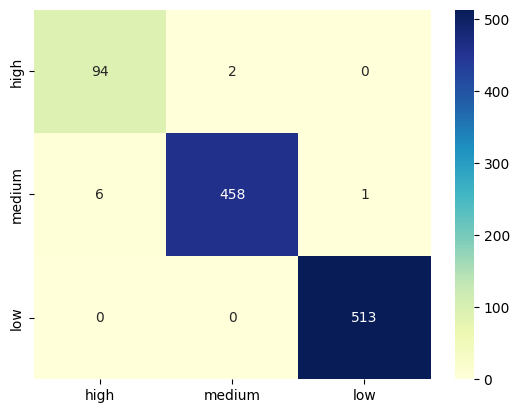

In [ ]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['high', 'medium', 'low']), 
                         columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', GaussianNB())])

gnb_grid = GridSearchCV(pipeline, 
                        param_grid={}, 
                        scoring='accuracy', 
                        cv=5,  # 5 fold cross validation 
                        n_jobs=-1,  # use all processors 
                        refit=True,  # refit the best model on the full development set 
                        return_train_score=True, 
                        verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
print_pretty_cv_results(gnb_grid)

<ipython-input-7-4367a86138e8>:12: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()


params,mean_train_score,mean_val_score,rank_val_score
{},0.877290,0.876753,1


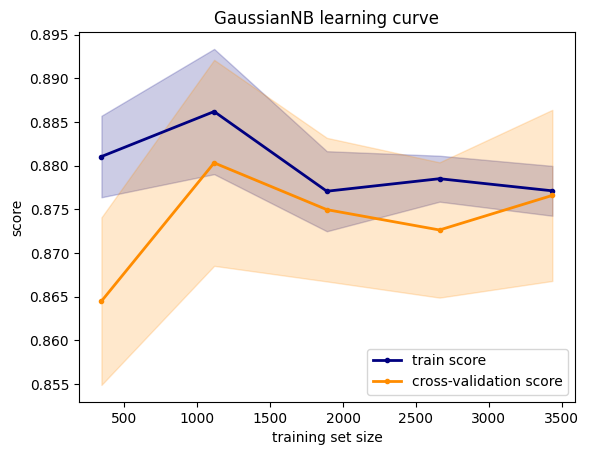

In [ ]:
plot_learning_curve(gnb_grid.best_estimator_, X, y)

## Evaluation on the test set

In [ ]:
y_pred = gnb_grid.best_estimator_.predict(X_test)
accuracy_score(y_pred, y_test)

0.8919925512104283

In [ ]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.85      0.83      0.84        96
         low       0.87      0.97      0.92       513
      medium       0.93      0.82      0.87       465

    accuracy                           0.89      1074
   macro avg       0.88      0.87      0.88      1074
weighted avg       0.89      0.89      0.89      1074



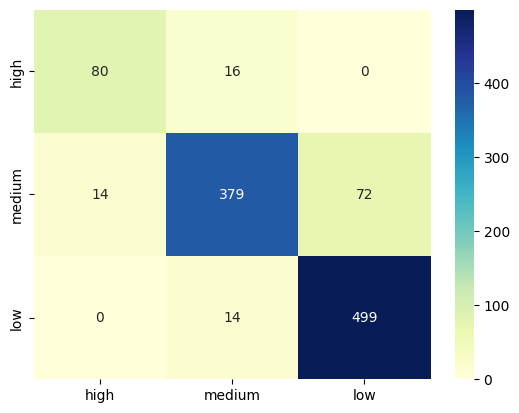

In [ ]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['high', 'medium', 'low']), 
                         columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', RandomForestClassifier())])

tuned_parameters = {'estimator__n_estimators': (10, 100, 1000, 1500, 2000), 
                    'estimator__bootstrap': (True, False), 
                    'estimator__max_depth': (10, 30, 60, 100), 
                    'estimator__min_samples_split': (2, 5, 10), 
                    'estimator__min_samples_leaf': (1, 2, 4), 
                    'estimator__max_features': (1, 'auto', 5)}

In [ ]:
rf_grid = GridSearchCV(pipeline, 
                       param_grid=tuned_parameters, 
                       scoring='accuracy', 
                       cv=5,  # 5 fold cross validation
                       n_jobs=-1,  # use all processors 
                       refit=True,  # refit the best model on the full development set 
                       return_train_score=True, 
                       verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


In [ ]:
print_pretty_cv_results(rf_grid)

<ipython-input-7-4367a86138e8>:12: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()


params,mean_train_score,mean_val_score,rank_val_score
"{'bootstrap': True, 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}",1.000000,0.984788,1
"{'bootstrap': True, 'max_depth': 60, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}",1.000000,0.984168,2
"{'bootstrap': False, 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",1.000000,0.984167,3
"{'bootstrap': True, 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}",1.000000,0.983859,4
"{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1500}",1.000000,0.983858,5
"{'bootstrap': True, 'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}",1.000000,0.983858,6
"{'bootstrap': True, 'max_depth': 100, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}",1.000000,0.983857,7
"{'bootstrap': True, 'max_depth': 100, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}",1.000000,0.983857,7
"{'bootstrap': True, 'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}",1.000000,0.983857,7
"{'bootstrap': True, 'max_depth': 100, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1500}",1.000000,0.983548,10


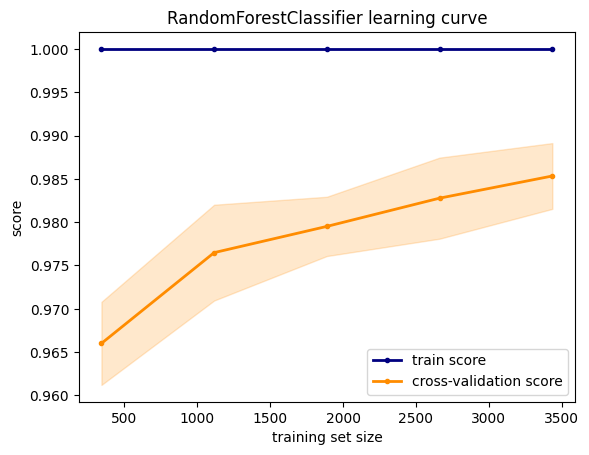

In [ ]:
plot_learning_curve(rf_grid.best_estimator_, X, y)

## Evaluation on the test set

In [ ]:
y_pred = rf_grid.best_estimator_.predict(X_test)
accuracy_score(y_pred, y_test)

0.9823091247672253

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.99      0.97      0.98        96
         low       0.98      0.99      0.98       513
      medium       0.98      0.98      0.98       465

    accuracy                           0.98      1074
   macro avg       0.98      0.98      0.98      1074
weighted avg       0.98      0.98      0.98      1074



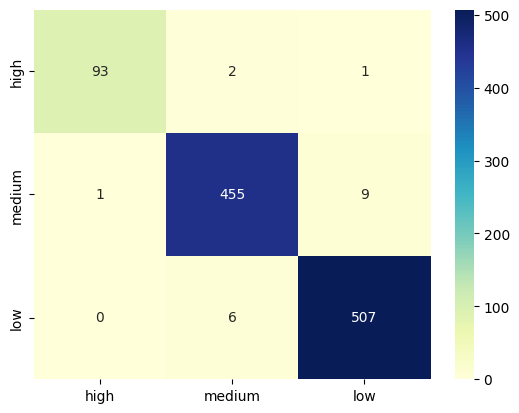

In [ ]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['high', 'medium', 'low']), 
                         columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

# Ensemble Classifier

### Voting Ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:

clf1 = RandomForestClassifier()
clf2 = SVC()


pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', VotingClassifier(estimators=[ ('rf', clf1), ('svc', clf2)],
                            voting='soft'))])

param = {'estimator__rf__n_estimators': [1000], 
                    'estimator__rf__bootstrap': [True], 
                    'estimator__rf__max_depth': [10], 
                    'estimator__rf__min_samples_split': [2], 
                    'estimator__rf__min_samples_leaf':[ 1], 
                    'estimator__rf__max_features': [1],
                    'estimator__svc__kernel':['linear'],
                    'estimator__svc__C':[1000],
                    'estimator__svc__probability':[True]}

pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', VotingClassifier(estimators=[('rf', clf1), ('svc', clf2)],
                            voting='soft'))])

en_grid = GridSearchCV(pipeline, 
                       param_grid=param,
                       scoring='accuracy', 
                       cv=5,  # 5 fold cross validation
                       n_jobs=-1,  # use all processors 
                       refit=True,  # refit the best model on the full development set 
                       return_train_score=True, 
                       verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
print_pretty_cv_results(en_grid)

<ipython-input-9-4367a86138e8>:12: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()


params,mean_train_score,mean_val_score,rank_val_score
"{'rf__bootstrap': True, 'rf__max_depth': 10, 'rf__max_features': 1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 1000, 'svc__C': 1000, 'svc__kernel': 'linear', 'svc__probability': True}",0.997594,0.985408,1


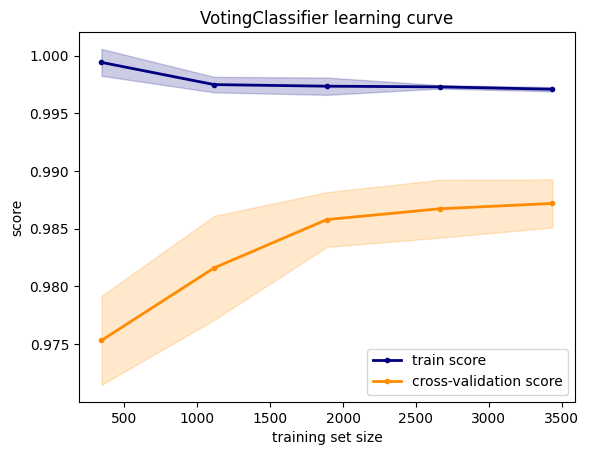

In [ ]:
plot_learning_curve(en_grid.best_estimator_, X, y)

# Evaluation on the test set

In [ ]:
y_pred = en_grid.best_estimator_.predict(X_test)
accuracy_score(y_pred, y_test)

0.9869646182495344

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.95      0.97      0.96        96
         low       0.99      1.00      0.99       513
      medium       0.99      0.98      0.98       465

    accuracy                           0.99      1074
   macro avg       0.98      0.98      0.98      1074
weighted avg       0.99      0.99      0.99      1074



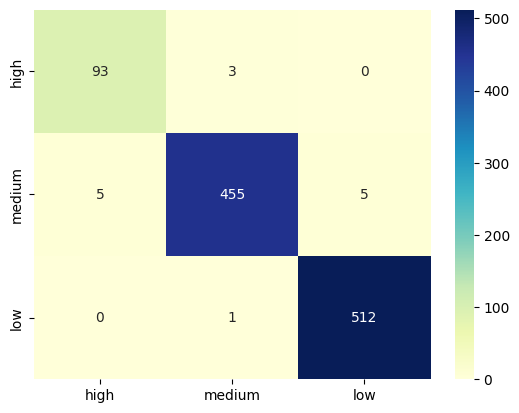

In [ ]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['high', 'medium', 'low']), 
                         columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

### Bagging Ensemble

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [31]:
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('estimator', BaggingClassifier(base_estimator=SVC(C=1000)))])

tuned_parameters = {
                    'estimator__n_estimators':[1000]
                   
                    }

In [32]:
bg_grid = GridSearchCV(pipeline, 
                       param_grid=tuned_parameters,
                       scoring='accuracy', 
                       cv=5,  # 5 fold cross validation
                       n_jobs=-1,  # use all processors 
                       refit=True,  # refit the best model on the full development set 
                       return_train_score=True, 
                       verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [33]:
print_pretty_cv_results(bg_grid)

<ipython-input-7-4367a86138e8>:12: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()


params,mean_train_score,mean_val_score,rank_val_score
{'n_estimators': 1000},0.996585,0.990065,1


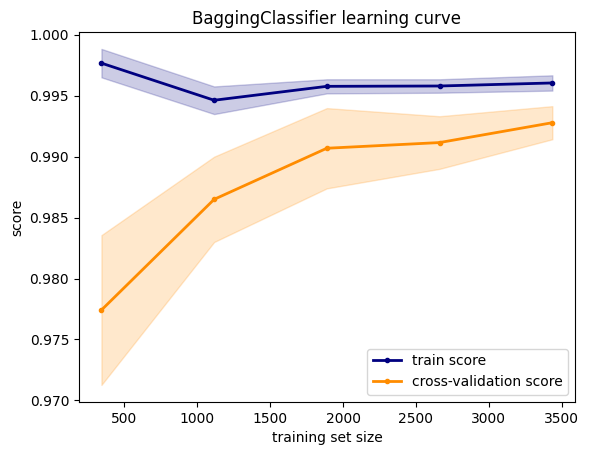

In [34]:
plot_learning_curve(bg_grid.best_estimator_, X, y)

## Evaluation on the test set

In [35]:
y_pred = bg_grid.best_estimator_.predict(X_test)
accuracy_score(y_pred, y_test)

0.9906890130353817

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.97      0.99      0.98        96
         low       0.99      0.99      0.99       513
      medium       0.99      0.99      0.99       465

    accuracy                           0.99      1074
   macro avg       0.98      0.99      0.99      1074
weighted avg       0.99      0.99      0.99      1074



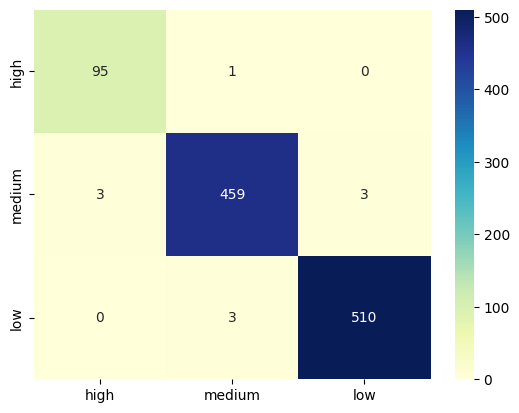

In [37]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['high', 'medium', 'low']), 
                         columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');